<a href="https://colab.research.google.com/github/ale-camer/Data-Engineering/blob/Finance/pcaEffect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# PACKAGES

import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

encoder = OrdinalEncoder()
scaler = MinMaxScaler()

# DATA & PREPROCESSING

data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00421/aps_failure_training_set.csv", sep='delimiter', header=None) # download data
data = data.iloc[14:,:] # deleting unnecesary rows
data = data[0].str.split(',', expand=True) # separating single column
data.columns = data.iloc[0,:] # renaming columns
data = data.fillna(method='ffill') # replacing NAs
data1 = encoder.fit_transform(data) # discretizing data
data1 = pd.DataFrame(scaler.fit_transform(data1)) # scaling data
data1.index, data1.columns = data.index, data.columns # naming columns and rows of scaled data
data1 = data1[data1['class'] != 0] # deleting unnecesary rows
X, y = data1.drop('class',axis=1), data1['class'] # separating dataset 
y = y.astype('int') # data to predict must be integer for the Logistic Regression algorithm 

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [2]:
# FUNCTION

def pcaEffect(X = X, y = y, lower_bound = 0.01, upper_bound = 1.0, interval = 0.01, test_size_ = 0.10, poly_grade = 1):

  """
  This function plot a graph that shows how the difference of accuracies, obtained by the prediction of the 10% of the dataset with the Logistic Regression model,  
  between a dataset and the same one applying Principal Component Analysis drops while incresing the amount of variance explained from 1% to 100% and consecuently the
  number of dimensions.
  """

  from sklearn.decomposition import PCA
  from sklearn import linear_model
  from sklearn.model_selection import train_test_split
  from sklearn.metrics import accuracy_score
  import matplotlib.pyplot as plt
  import pandas as pd
  import numpy as np
  from tqdm import tqdm
  import warnings
  warnings.filterwarnings('ignore')
  print("Progress:")
  props = np.arange(lower_bound, upper_bound, interval)
  X2 = X.copy()

  statsList = []
  for prop in tqdm(props):
    
    X3 = pd.DataFrame(PCA(n_components = prop).fit_transform(X2))

    x_train1, x_test1, y_train1, y_test1 = train_test_split(X, y, test_size = test_size_)
    x_train2, x_test2, y_train2, y_test2 = train_test_split(X3, y, test_size = test_size_)

    lr_model1 = linear_model.LogisticRegression().fit(x_train1, y_train1).predict(x_test1)
    lr_model2 = linear_model.LogisticRegression().fit(x_train2, y_train2).predict(x_test2)

    model1_acc = round(accuracy_score(y_test1, lr_model1) * 100, 2)
    model2_acc = round(accuracy_score(y_test2, lr_model2) * 100, 2)

    diff = round(abs(model1_acc - model2_acc), 2)
    q = len(X3.columns)
    
    statsList.append((prop, q, diff))

  statsList = pd.DataFrame(statsList, columns = ['Proportion', 'Dimensions', 'Accuracy Difference'])

  fig = plt.figure(figsize = (10, 5))

  x1 = fig.add_subplot(111)
  x1.bar(statsList['Proportion'], statsList['Dimensions'], color = 'g', label = 'Dimensions', width = 0.01, alpha = 0.70)
  x1.set_ylabel('Dimensions')
  x1.legend(loc = 'best')
  x1.set_xlabel('Variance Explaiend')

  x2 = x1.twinx()
  x2.scatter(statsList['Proportion'], statsList['Accuracy Difference'], color = 'r', label = 'Accuracy Difference')
  z = np.polyfit(statsList['Proportion'], statsList['Accuracy Difference'], poly_grade)
  p = np.poly1d(z)
  x2.plot(statsList['Proportion'], p(statsList['Proportion']), 'r--', alpha = 0.5)
  x2.set_ylabel('Accuracy Difference')
  x2.legend(loc = 'best')

  plt.title(f'PCA Effect. Total amount of columns: {len(X.columns)}')
  plt.show()

Progress:


100%|██████████| 99/99 [07:42<00:00,  4.67s/it]


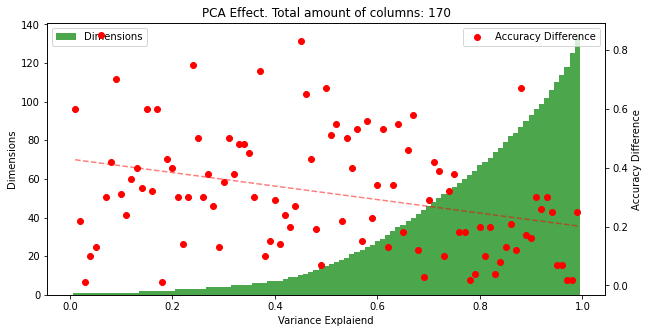

In [3]:
# OUTPUT

pcaEffect(X,y)